# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.233437,True,5.320923
1,-0.433859,True,5.787497
2,-1.331633,True,3.795927
3,0.135155,False,-0.688696
4,-1.286309,False,-1.053001
...,...,...,...
995,0.729581,True,4.374632
996,1.705962,False,0.994235
997,0.677094,True,5.065784
998,0.234507,True,4.440153


<Axes: xlabel='v0'>

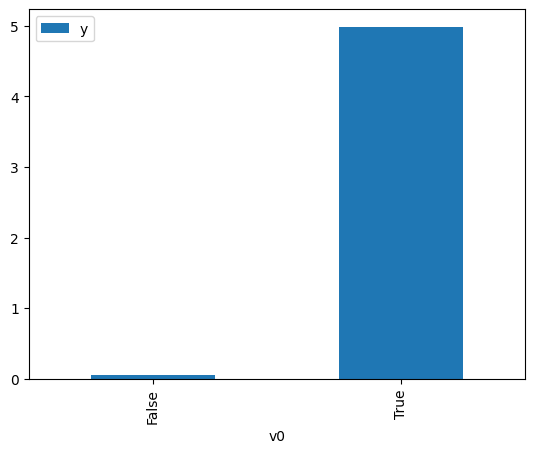

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

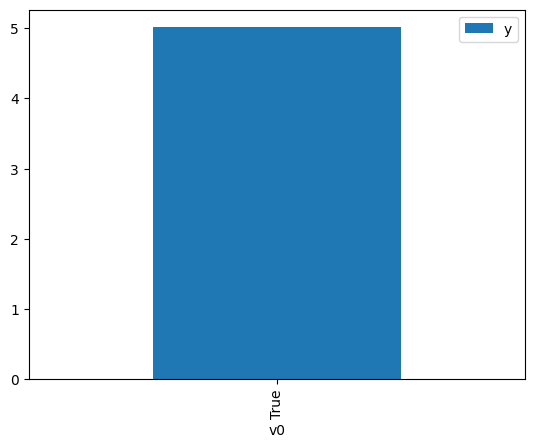

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.236803,False,1.626469,0.461295,2.167808
1,0.393353,False,0.489139,0.443223,2.256200
2,0.982137,False,-1.005355,0.376952,2.652854
3,-1.128249,False,-1.115056,0.618002,1.618118
4,-1.486500,False,-0.921089,0.656570,1.523067
...,...,...,...,...,...
995,1.705962,False,0.994235,0.301565,3.316029
996,1.164398,False,0.610607,0.357220,2.799393
997,-0.107591,False,-2.534468,0.501345,1.994633
998,0.031069,False,0.989869,0.485194,2.061033


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.236984,True,5.098221,0.370108,2.701915
1,-1.391304,True,4.713027,0.353503,2.828831
2,1.690668,True,5.486936,0.696931,1.434862
3,-1.467350,True,5.762454,0.345446,2.894812
4,0.743273,True,7.563717,0.596566,1.676260
...,...,...,...,...,...
995,0.934239,True,4.530152,0.617790,1.618672
996,0.737230,True,5.703776,0.595888,1.678168
997,-0.197850,True,5.484465,0.488140,2.048592
998,0.163546,True,5.791961,0.530210,1.886046


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              7459.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):                        0.00
Time:                        22:32:07   Log-Likelihood:                         -1377.8
No. Observations:                1000   AIC:                                      2760.
Df Residuals:                     998   BIC:                                      2770.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3069      0.031      9.782      0.000       0.245       0.368
x2             4.9934      0.043    115.391      0.000       4.908       5.078
==============================================================================
Omnibus:                        0.396   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.485
Skew:                           0.021   Prob(JB):                        0.785
Kurtosis:                       2.900   Cond. No.                         1.51
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""